In [1]:
import torch
#from data import *
import scipy
from scipy.stats import norm
import matplotlib.pyplot as plt
from torch.optim import Adagrad
from torch.optim import Adam
from tqdm import tqdm
#from vae import *
#import argparse

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.gridspec as gridspec


In [12]:
HIDDEN=32
BATCH_SIZE=64
EPOCHS=50
LR=2e-2
LATENT=128


#specify the device
device="cuda:0"

In [13]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim=2):
        """
            @param input_dim: input dimension of the data
            @param hidden_dim: hidden dimension of the MLPs
            @param latent_dim: output dimension of MLPs
            @------------------@
            @return: None
        """
        super(VAE,self).__init__()
        self.en = nn.Sequential(
            nn.Linear(input_dim,hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.Tanh()
        )
        self.mu = nn.Linear(hidden_dim, latent_dim)
        self.var = nn.Linear(hidden_dim,latent_dim)
        
        self.de = nn.Sequential(
            nn.Linear(latent_dim,hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.Tanh()
        )

        self.final_layer=nn.Sequential(
            nn.Linear(hidden_dim,input_dim),
        )

        
          
    def encode(self,x):
        #x = torch.flatten(x)
        res = self.en(x)
        mu = self.mu(res)
        log_var = self.var(res)
        
        return mu,log_var
            
    def decode(self,x):
        res = self.de(x)
        res = self.final_layer(res)
        return res
    def reparameterize(self,mu,log_var):
        epsilon = torch.normal(mu,torch.exp(0.5 * log_var))
        return mu + log_var * epsilon
    def forward(self,x):
        mu, log_var = self.encode(x)
        norm = self.reparameterize(mu,log_var)
        res = self.decode(norm)
        return (res, x, mu,log_var)



    def loss_fc(self,x,*args):
        (res, x, mu, log_var) = self.forward(x)
        recon_loss = F.mse_loss(x,res)
        KL_divergence = torch.mean(-0.5 * torch.sum((1 + log_var - mu**2 - torch.exp(log_var)),dim=1), dim=0)
        KL_divergence.required_grad = True
        loss = recon_loss + KL_divergence
        
        return dict({'loss': loss, 'recon_loss': recon_loss, 'kl_loss': KL_divergence})



    def generate(self,x):
        return self.forward(x)[0]


In [14]:
from scipy.io import loadmat

def get_minibatch(x,batch_size,device='cpu'):
    indices = torch.randperm(x.shape[0])[:batch_size]
    return x[indices].reshape(batch_size, -1).to(device)
def get_data(path, nums=25000):
    img_data = scipy.io.loadmat(path)["data"].T / 255.
    img_data = torch.Tensor(img_data)
    img_data = get_minibatch(img_data,nums)
    print(f"Shape of a data point: {img_data.shape}")
    print(f"Example data {img_data[0:1].shape}")
    return img_data



In [15]:
x = get_data("Data/mnist.mat")

Shape of a data point: torch.Size([25000, 784])
Example data torch.Size([1, 784])


In [16]:
def AEVB(data, model, optimizer, input_dim, output_dim,epochs, batch_size):
    full_loss, kld, recon = [],[],[]
    for epc in range(epochs):
        fl,kl,rec = 0,0,0
        steps = x.shape[0] // batch_size
        for _ in tqdm(range(steps)):
            batch = get_minibatch(x,batch_size, device)
            optimizer.zero_grad()
 
            losses = model.loss_fc(batch)
        
            fl += losses["loss"].item() / batch_size
            kl += losses["kl_loss"].item() / batch_size
            rec += losses["recon_loss"].item() / batch_size
        
            losses["loss"].backward()

            optimizer.step()
        fl /= steps; kl /= steps; rec /= steps
        full_loss.append(fl); kld.append(kl); recon.append(rec)
        print(f"Epoch {epc + 1}\tFull loss: {full_loss[-1]}\trecon loss: {recon[-1]}\tkl_divergence: {kld[-1]}")
        
    return model, full_loss, kld, recon 





In [17]:
#Model 
model = VAE(x.shape[1],HIDDEN,LATENT).to(device)
# Optimizer

optimizer = Adam(model.parameters(), lr=LR)

In [18]:
(model, full_loss, kld, recon) = AEVB(data=x,
                                      model=model,
                                      optimizer=optimizer,
                                      input_dim=x.shape[1],
                                      output_dim=x.shape[1],
                                      batch_size=BATCH_SIZE,
                                      epochs=EPOCHS)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 340.45it/s]


Epoch 1	Full loss: 0.008110450708623736	recon loss: 0.001155029963522863	kl_divergence: 0.00695542074804857


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 335.17it/s]


Epoch 2	Full loss: 0.000910434682513229	recon loss: 0.0007342624309389159	kl_divergence: 0.00017617225157431302


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 342.00it/s]


Epoch 3	Full loss: 0.0007970228516616119	recon loss: 0.0006594253932304967	kl_divergence: 0.00013759745749830006


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 331.04it/s]


Epoch 4	Full loss: 0.0007406018137072142	recon loss: 0.0006121564880371667	kl_divergence: 0.0001284453251290147


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 328.28it/s]


Epoch 5	Full loss: 0.0007097577277678423	recon loss: 0.0005811032066002297	kl_divergence: 0.0001286545200295782


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 319.74it/s]


Epoch 6	Full loss: 0.0006833977251050947	recon loss: 0.0005594867308480808	kl_divergence: 0.00012391099360404322


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 339.31it/s]


Epoch 7	Full loss: 0.0006565421421188288	recon loss: 0.0005378739301634666	kl_divergence: 0.00011866821027629507


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 328.49it/s]


Epoch 8	Full loss: 0.0006359552267568711	recon loss: 0.0005192199057021823	kl_divergence: 0.00011673532114797033


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 322.49it/s]


Epoch 9	Full loss: 0.0006118116733164359	recon loss: 0.0005029306888060931	kl_divergence: 0.00010888098363349668


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 309.41it/s]


Epoch 10	Full loss: 0.0005872241979560409	recon loss: 0.00048551263014535203	kl_divergence: 0.00010171156801590816


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 331.00it/s]


Epoch 11	Full loss: 0.0005633907656794271	recon loss: 0.0004688082833756478	kl_divergence: 9.458248206124736e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 337.55it/s]


Epoch 12	Full loss: 0.0005374396572826812	recon loss: 0.0004513092800968876	kl_divergence: 8.613037754026337e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 323.31it/s]


Epoch 13	Full loss: 0.0005221813895518725	recon loss: 0.00043973482373612337	kl_divergence: 8.244656669259525e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 338.40it/s]


Epoch 14	Full loss: 0.0004986061004157632	recon loss: 0.0004249786693178929	kl_divergence: 7.362743173218451e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 336.50it/s]


Epoch 15	Full loss: 0.00047724996603882083	recon loss: 0.0004105642975236361	kl_divergence: 6.668566875771667e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 332.03it/s]


Epoch 16	Full loss: 0.0004655558370405999	recon loss: 0.0004042166242680441	kl_divergence: 6.133921284718105e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 342.89it/s]


Epoch 17	Full loss: 0.00043852299590630886	recon loss: 0.0003858201959445022	kl_divergence: 5.270280059612094e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 313.02it/s]


Epoch 18	Full loss: 0.0004225175011341866	recon loss: 0.0003755603308747642	kl_divergence: 4.695717052061063e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 332.64it/s]


Epoch 19	Full loss: 0.00041053128975013703	recon loss: 0.00036846460410369896	kl_divergence: 4.2066685124061616e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 327.33it/s]


Epoch 20	Full loss: 0.0003927838377421722	recon loss: 0.00035760854064928704	kl_divergence: 3.5175297596605305e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 331.64it/s]


Epoch 21	Full loss: 0.0003768793675147045	recon loss: 0.00034779812357066056	kl_divergence: 2.90812437574809e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 331.66it/s]


Epoch 22	Full loss: 0.00036610665787847185	recon loss: 0.0003414914423140148	kl_divergence: 2.461521603086462e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 337.25it/s]


Epoch 23	Full loss: 0.000349588509878884	recon loss: 0.0003304184367432474	kl_divergence: 1.9170073340855874e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 329.26it/s]


Epoch 24	Full loss: 0.00033966316565429457	recon loss: 0.00032452899285066776	kl_divergence: 1.5134173326003247e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 334.59it/s]


Epoch 25	Full loss: 0.0003311979285148808	recon loss: 0.0003188054407916915	kl_divergence: 1.2392487014249826e-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 333.21it/s]


Epoch 26	Full loss: 0.0003229572158605338	recon loss: 0.00031331560092393116	kl_divergence: 9.641615048540421e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 338.53it/s]


Epoch 27	Full loss: 0.0003184177854564041	recon loss: 0.00031020511120844347	kl_divergence: 8.212674136022823e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 334.91it/s]


Epoch 28	Full loss: 0.0003156974247525422	recon loss: 0.00030819640259067407	kl_divergence: 7.501022684244582e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 251.37it/s]


Epoch 29	Full loss: 0.00031237582450744527	recon loss: 0.0003055685341585045	kl_divergence: 6.807290479534855e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 334.13it/s]


Epoch 30	Full loss: 0.0003087119068741464	recon loss: 0.0003025220900338191	kl_divergence: 6.189816579139099e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 333.26it/s]


Epoch 31	Full loss: 0.00030693824698503776	recon loss: 0.00030098333693622876	kl_divergence: 5.954910347309823e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 336.64it/s]


Epoch 32	Full loss: 0.00030652986084206554	recon loss: 0.00030087974468747585	kl_divergence: 5.650116117277111e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 334.18it/s]


Epoch 33	Full loss: 0.0003043959221731012	recon loss: 0.00029918431335737783	kl_divergence: 5.211608703785505e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 258.23it/s]


Epoch 34	Full loss: 0.0003035949121486061	recon loss: 0.0002987583758136353	kl_divergence: 4.836536596159044e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 328.63it/s]


Epoch 35	Full loss: 0.00030174312675789665	recon loss: 0.00029709174399240277	kl_divergence: 4.651383119963635e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 337.84it/s]


Epoch 36	Full loss: 0.0003005898000153068	recon loss: 0.0002962610426132018	kl_divergence: 4.328757831199954e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 343.82it/s]


Epoch 37	Full loss: 0.0003007058061671276	recon loss: 0.000296579980222771	kl_divergence: 4.125825795106208e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 318.41it/s]


Epoch 38	Full loss: 0.00030083290990800236	recon loss: 0.0002969710459299863	kl_divergence: 3.86186420189169e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 335.92it/s]


Epoch 39	Full loss: 0.000299294473295912	recon loss: 0.0002955852300286866	kl_divergence: 3.709242353066563e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 338.10it/s]


Epoch 40	Full loss: 0.00029716958890322785	recon loss: 0.00029363318238980493	kl_divergence: 3.5364068678926484e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 339.64it/s]


Epoch 41	Full loss: 0.0002975055703875394	recon loss: 0.0002941219336114442	kl_divergence: 3.3836365149069866e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 327.65it/s]


Epoch 42	Full loss: 0.0002976143236409347	recon loss: 0.0002942918953545487	kl_divergence: 3.3224286595120645e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 335.49it/s]


Epoch 43	Full loss: 0.00029592196612308425	recon loss: 0.0002926627132229698	kl_divergence: 3.259253441147172e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 331.48it/s]


Epoch 44	Full loss: 0.0002970113578694276	recon loss: 0.00029379366165719543	kl_divergence: 3.2176966599833506e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 319.75it/s]


Epoch 45	Full loss: 0.00029625383919128814	recon loss: 0.0002931073721414671	kl_divergence: 3.1464675908538107e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 335.65it/s]


Epoch 46	Full loss: 0.00029665270815782535	recon loss: 0.00029352975946564516	kl_divergence: 3.122948673523915e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 335.56it/s]


Epoch 47	Full loss: 0.0002938383046197347	recon loss: 0.00029077482535145606	kl_divergence: 3.063479324247545e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 272.71it/s]


Epoch 48	Full loss: 0.00029545414361517683	recon loss: 0.0002923660425063318	kl_divergence: 3.0881009782509255e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 326.41it/s]


Epoch 49	Full loss: 0.0002945062440957349	recon loss: 0.0002914365210856956	kl_divergence: 3.069723383165323e-06


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 390/390 [00:01<00:00, 338.66it/s]

Epoch 50	Full loss: 0.00029418685015302913	recon loss: 0.00029119936785159203	kl_divergence: 2.987481760404383e-06


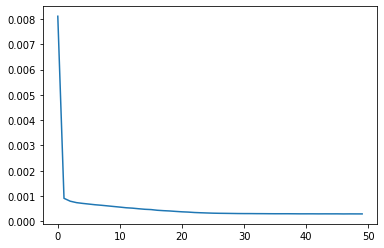

In [19]:
%matplotlib inline

plt.plot([i for i in range(len(full_loss))], full_loss)

In [20]:
def visualization(x):
    kx = get_minibatch(x,25,device)
    gen = model.generate(kx).cpu().detach().numpy()
    kx = kx.cpu().detach().numpy()
    fig, ax = plt.subplots(5,5)
    for i in range(1,6):
        for j in range(1,6):
            ax[i-1,j-1].axis("off")
            tmp = kx[i*j - 1]
            tmp = tmp.reshape(28,28)
            ax[i - 1,j - 1].imshow(tmp,cmap="gray")
    fig2, ax2 = plt.subplots(5,5)
    for i in range(1,6):
        for j in range(1,6):
            ax2[i-1,j-1].axis("off")
            tmp = gen[i*j - 1]
            tmp = tmp.reshape(28,28)
            ax2[i - 1,j - 1].imshow(tmp,cmap="gray")
    fig.show()
    fig2.show()

/tmp/ipykernel_2161/3618367855.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_2161/3618367855.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


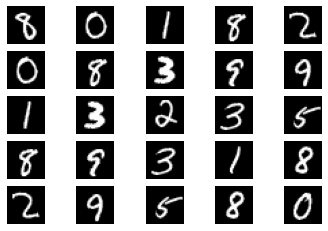

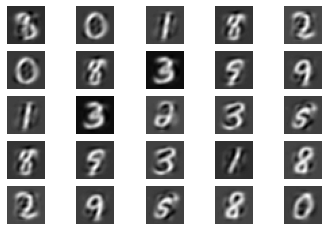

In [21]:
visualization(x)